In [2]:
import polars as pl
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tqdm import tqdm

import polars.selectors as cs
import wandb

from atma_16.dataset.dataset import AtmaData16Loader

exp_name = "904_session_based_yad_eda"
input_dir = Path("../input")
output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

dl = AtmaData16Loader(input_dir=input_dir)
label = dl.load_train_label()
train_log = dl.load_train_log()
test_log = dl.load_test_log()

<Axes: xlabel='train_count', ylabel='test_count'>

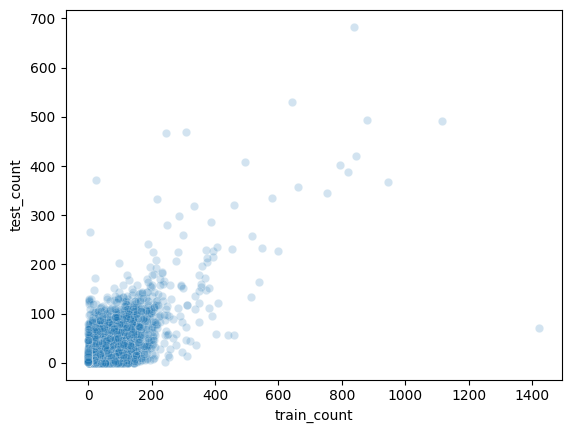

In [13]:
count_df = (
    train_log.group_by("yad_no")
    .count()
    .join(test_log.group_by("yad_no").count(), on="yad_no", how="outer")
    .fill_null(0)
    .select(
        pl.col("yad_no"),
        pl.col("count").alias("train_count"),
        pl.col("count_right").alias("test_count"),
        (pl.col("count") / (pl.col("count") + pl.col("count_right"))).alias("train_ratio"),
    )
)
sns.scatterplot(data=count_df.to_pandas(), x="train_count", y="test_count", markers=".", alpha=0.2)

In [15]:
train_log

session_id,seq_no,yad_no
i64,i64,i64
0,0,2395
1,0,13535
2,0,123
3,0,8475
4,0,96
4,1,898
5,0,6868
6,0,8602
7,0,13106


In [17]:
train_log.with_columns((pl.col("seq_no").max().over("session_id") + 1).alias("session_seq_len"))

session_id,seq_no,yad_no,session_seq_len
i64,i64,i64,i64
0,0,2395,1
1,0,13535,1
2,0,123,1
3,0,8475,1
4,0,96,2
4,1,898,2
5,0,6868,1
6,0,8602,1
7,0,13106,1


yad_no,count,session_seq_len
i64,u32,f64
8268,88,2.147727
6032,2,1.0
8530,38,1.342105
3281,21,1.333333
1188,20,1.1
11412,9,1.333333
5904,16,1.375
5642,100,2.07
6425,67,1.865672


['yad_no',
 'this_session_seq_len_yad_mean',
 'another_session_seq_len_yad_mean',
 'this_count_yad_mean',
 'another_count_yad_mean',
 'this_ratio_yad_mean',
 'another_ratio_yad_mean']